In [1]:
using ITensors, ITensorMPS, Plots
using Plots.PlotMeasures

In [2]:
#nQ = 2 #Number of qubits per lattice site
N = 3 #Number of lattice sites per dimension
d = 1 #Number of spatial dimensions
dx = 1 #Lattice spacing

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (2*pi)/(N*dx) #Discrete change in momentum
#= p_min = -pi/dx #Minimum momentum 
p_max = n_0*dp
p_i = Float64[] #Momentum at each lattice site
for i in 1:N
    #push!(p_i, p_min + (i-1)*dp)
    push!(p_i, -p_max+(i-1/2)*dp)
end =#
p_i = range(1/2*dp, stop = dp*(N+1/2), length = (N+1))[1:end-1]
#om_p = 2/dx*sqrt(sum([sin(p_i[i]*dx/2)^2 for i in 1:N]))
#om_p = 2/dx*sqrt(sum([sin(pi*(k + 1/2)/N)^2 for k in 0:N-1]))

om_i = Float64[] #List of omega values for each lattice site (eq. 12)
for i in 1:N
    push!(om_i, (2/dx)*abs(sin(p_i[i]*dx/2)))
end

In [3]:
H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=4) #Create ITensor "SFT" sites
#Hamiltonian = MPO(H,sites) #Define the Hamiltonian as a matrix product operator

3-element Vector{Index{Int64}}:
 (dim=4|id=465|"Boson,Site,n=1")
 (dim=4|id=75|"Boson,Site,n=2")
 (dim=4|id=208|"Boson,Site,n=3")

In [4]:
#psi_0 = random_mps(sites;linkdims=10) #Initial guess wave function for the DMRG algorithm. This creates a random MPS with m=10

#= nsweeps = 10 #Number of sweeps (i.e. iterations) that the DMRG algorithm will perform
maxdim = [10,20,50,100,200] #Maximum bond dimension for each sweep, starting small then scaling up for higher accuracy
cutoff = [1E-10] =#

#energy_gs, psi_gs = dmrg(Hamiltonian, psi_0; nsweeps, maxdim, cutoff) #Use the DMRG algorithm to obtain the ground state
psi_gs = MPS(sites, ["0", "0", "0"])

#energy_p1, psi_p1 = dmrg(Hamiltonian, [psi_gs], psi_0; nsweeps, maxdim, cutoff) #Obtain the first one-particle momentum eigenstate
psi_p1 = MPS(sites, ["1", "0", "0"])

psi_p2 = MPS(sites, ["0", "0", "1"]) #p2 state
psi_p0 = MPS(sites, ["0", "1", "0"]) #p0 state
psi_p1p2 = MPS(sites, ["1", "0", "1"]) #p1p2 state

MPS
[1] ((dim=4|id=465|"Boson,Site,n=1"), (dim=1|id=734|"Link,l=1"))
[2] ((dim=1|id=734|"Link,l=1"), (dim=4|id=75|"Boson,Site,n=2"), (dim=1|id=185|"Link,l=2"))
[3] ((dim=1|id=185|"Link,l=2"), (dim=4|id=208|"Boson,Site,n=3"))


In [5]:
function alpha_i(g::Real, m::Real, i::Real)
    prefactor = 2/sqrt(N) * 1/sqrt(2*om_i[i])
    #sumterms = sum([exp(im*(s+1)*om_i[i])*sin(2pi*(s+1)*((i-1) + 1/2)/N) for s in 0:n_0-1])
    sumterms = exp(im*(m)*om_i[i])*sin(2pi*(m)*((i-1) + 1/2)/N)
    return g*prefactor*sumterms
end

alpha_i (generic function with 1 method)

In [6]:
function MakeMPO(g::Real)
    OS = OpSum()
    for m in n_0:-1:0
        if m == n_0
            OS += -im*H*n_0
        else
            OS += im*H
        end
        for i in 1:N
            OS += alpha_i(g, m, i), "a†", i
            OS += -1.0*conj(alpha_i(g, m, i)), "a", i
        end
    end

    FinalMPO = MPO(OS, sites)

    return FinalMPO
end

function tdvpTEO(g::Real, t::Real)
    return tdvp(MakeMPO(g), t, psi_gs; nsteps=1, maxdim=300, cutoff=1e-15)
end

tdvpTEO (generic function with 1 method)

In [7]:
function tebdTEO(g::Real, dt::Real)
    oplist = []
    for i in 1:N
        TE_comp = ITensor()
        for m in n_0:-1:0
            if m == n_0
                TE_comp += -im*(om_i[i]*dp*n_0)/(2pi)*dt * scalar(op("a", sites[i]) * op("a†", sites[i])) * op("Id", sites[i]) - im*(om_i[i]*dp*n_0)/(2pi)*dt*(1/2)*(2pi/dp) * op("Id", sites[i])
            else
                TE_comp += im*(om_i[i]*dp)/(2pi)*dt * scalar(op("a", sites[i]) * op("a†", sites[i])) * op("Id", sites[i]) + im*(om_i[i]*dp)/(2pi)*dt*(1/2)*(2pi/dp) * op("Id", sites[i])
            end
            TE_comp += im*alpha_i(g, m, i)*dt * op("a†", sites[i]) - im*conj(alpha_i(g, m, i))*dt * op("a", sites[i])
        end
        push!(oplist, TE_comp)
    end

    return prod([exp(oplist[i]) for i in 1:N])
end

tebdTEO (generic function with 1 method)

In [8]:
analytic_expval_list_gs = [1.000000000000000000e+00,
    9.975031223974600847e-01,
    9.900498337491679957e-01,
    9.777512371933363422e-01,
    9.607894391523231770e-01,
    9.394130628134758076e-01,
    9.139311852712280748e-01,
    8.847059049434834455e-01,
    8.521437889662112353e-01,
    8.166864825981107190e-01,
    7.788007830714047675e-01,
    7.389684882589441228e-01,
    6.976763260710309167e-01,
    6.554062543268404095e-01,
    6.126263941844158900e-01,
    5.697828247309228988e-01,
    5.272924240430483245e-01,
    4.855368951540792177e-01,
    4.448580662229409399e-01,
    4.055545050633203585e-01,
    3.678794411714421675e-01]

analytic_expval_list_p1 = [0.000000000000000000e+00,
    1.246878902996826060e-03,
    4.950249168745843135e-03,
    1.099970141842504176e-02,
    1.921578878304647589e-02,
    2.935665821292113287e-02,
    4.112690333720529084e-02,
    5.418823667778839559e-02,
    6.817150311729694434e-02,
    8.268950636305874569e-02,
    9.735009788392563757e-02,
    1.117689838491653515e-01,
    1.255817386927856605e-01,
    1.384545712265451145e-01,
    1.500934665751819941e-01,
    1.602514194555721416e-01,
    1.687335756937755893e-01,
    1.754002033744112288e-01,
    1.801675168202911681e-01,
    1.830064704098234296e-01,
    1.839397205857211670e-01]

analytic_expval_list_p2 = [0.000000000000000000e+00,
    1.246878902996826060e-03,
    4.950249168745843135e-03,
    1.099970141842504176e-02,
    1.921578878304647589e-02,
    2.935665821292113287e-02,
    4.112690333720529084e-02,
    5.418823667778839559e-02,
    6.817150311729694434e-02,
    8.268950636305874569e-02,
    9.735009788392563757e-02,
    1.117689838491653515e-01,
    1.255817386927856605e-01,
    1.384545712265451145e-01,
    1.500934665751819941e-01,
    1.602514194555721416e-01,
    1.687335756937755893e-01,
    1.754002033744112288e-01,
    1.801675168202911681e-01,
    1.830064704098234296e-01,
    1.839397205857211670e-01]

analytic_expval_list_p1p2 = [0.000000000000000000e+00,
    1.558598628746033473e-06,
    2.475124584372923506e-05,
    1.237466409572818152e-04,
    3.843157756609298366e-04,
    9.173955691537858358e-04,
    1.850710650174239519e-03,
    3.319029496514541537e-03,
    5.453720249383759745e-03,
    8.372312519259701019e-03,
    1.216876223549070990e-02,
    1.690505880718626980e-02,
    2.260471296470143582e-02,
    2.924852817160766838e-02,
    3.677289931091961422e-02,
    4.507071172187968044e-02,
    5.399474422200822160e-02,
    6.336332346900609702e-02,
    7.296784431221794986e-02,
    8.258166977243286411e-02,
    9.196986029286062514e-02]

21-element Vector{Float64}:
 0.0
 1.5585986287460335e-6
 2.4751245843729235e-5
 0.00012374664095728182
 0.00038431577566092984
 0.0009173955691537858
 0.0018507106501742395
 0.0033190294965145415
 0.00545372024938376
 0.008372312519259701
 0.01216876223549071
 0.01690505880718627
 0.022604712964701436
 0.02924852817160767
 0.036772899310919614
 0.04507071172187968
 0.05399474422200822
 0.0633633234690061
 0.07296784431221795
 0.08258166977243286
 0.09196986029286063

In [9]:
g_list = range(0, stop=1, length=21)

0.0:0.05:1.0

In [10]:
exp_val_list_gs = []
exp_val_list_p1 = []
exp_val_list_p2 = []
exp_val_list_p0 = []
exp_val_list_p1p2 = []
for g in range(0, stop=1, length=21)
    Psi = tdvp(MakeMPO(g), dx, psi_gs; nsteps=1, maxdim=300, cutoff=1e-15) #tdvpTEO(g, dx)
    normalize!(Psi)

    exp_val_gs = abs2(inner(psi_gs, Psi))
    exp_val_p1 = abs2(inner(psi_p1, Psi))
    exp_val_p2 = abs2(inner(psi_p2, Psi))
    exp_val_p0 = abs2(inner(psi_p0, Psi))
    exp_val_p1p2 = abs2(inner(psi_p1p2, Psi))
    push!(exp_val_list_gs, exp_val_gs)
    push!(exp_val_list_p1, exp_val_p1)
    push!(exp_val_list_p2, exp_val_p2)
    push!(exp_val_list_p0, exp_val_p0)
    push!(exp_val_list_p1p2, exp_val_p1p2)
end

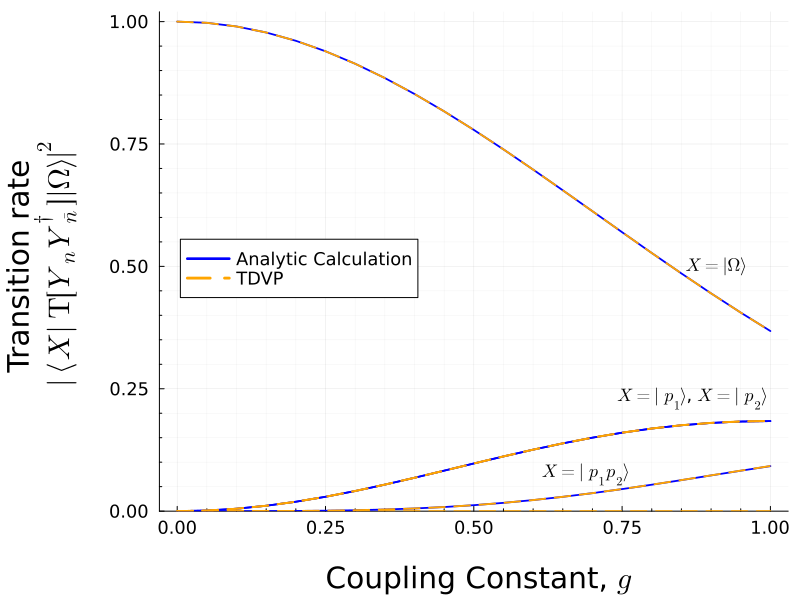

In [11]:
gr()
default(size=(800, 600))
plot(g_list, analytic_expval_list_gs, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_expval_list_p1, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_expval_list_p2, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_expval_list_p1p2, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_gs, linewidth=1.9, label="TDVP", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_p1, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_p2, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_p0, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_p1p2, linewidth=1.9, label="", linestyle=:dash, color="orange")

# Add text annotations
annotate!(0.91, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.87, 0.23, text("\$X = |p_1\\rangle\$, \$X = |p_2\\rangle\$", 12))
annotate!(0.69, 0.075, text("\$X = |p_1p_2\\rangle\$", 12))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:left, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Fig 1 Reproduced (TDVP)")

In [12]:
exp_val_list_gs_2 = []
exp_val_list_p1_2 = []
exp_val_list_p2_2 = []
exp_val_list_p0_2 = []
exp_val_list_p1p2_2 = []
dt = dx #n_0*dt = n_0*dx is the total evolution time. But since n_0 is already hardcoded into the operator, we only need to input dt=dx into the time evolution operator function (tebdTEO)
num_steps = 1 #Number of steps in the TEBD algorithm. To reduce trotter error, we want to break down the full application of dt into smaller steps
step_width = dt/num_steps #Width of each step
for g in range(0, stop=1, length=21)
    Psi = copy(psi_gs)
    for t_step in 1:num_steps
        Psi = apply(tebdTEO(g, step_width), Psi; maxdim=300, cutoff=1e-15)
    end
    normalize!(Psi)

    exp_val_gs_2 = abs2(inner(psi_gs, Psi))
    exp_val_p1_2 = abs2(inner(psi_p1, Psi))
    exp_val_p2_2 = abs2(inner(psi_p2, Psi))
    exp_val_p0_2 = abs2(inner(psi_p0, Psi))
    exp_val_p1p2_2 = abs2(inner(psi_p1p2, Psi))
    push!(exp_val_list_gs_2, exp_val_gs_2)
    push!(exp_val_list_p1_2, exp_val_p1_2)
    push!(exp_val_list_p2_2, exp_val_p2_2)
    push!(exp_val_list_p0_2, exp_val_p0_2)
    push!(exp_val_list_p1p2_2, exp_val_p1p2_2)
end

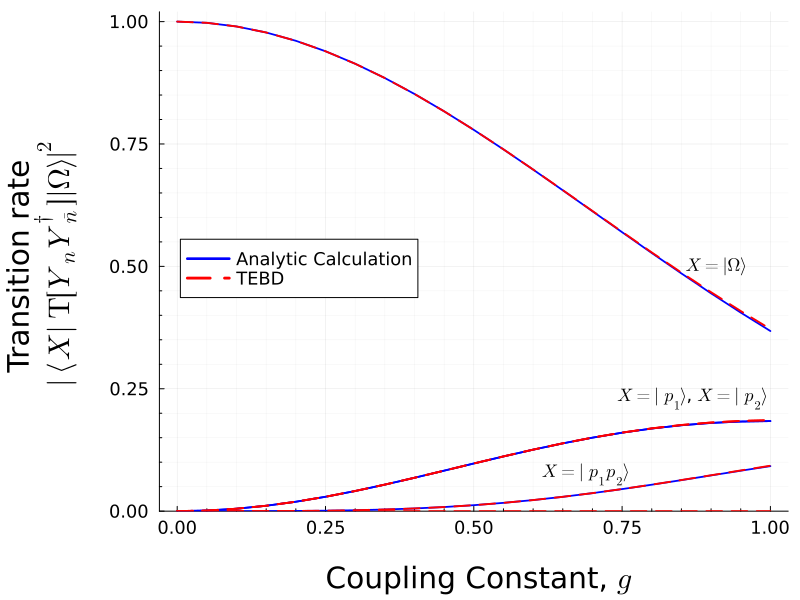

In [13]:
gr()
default(size=(800, 600))
plot(g_list, analytic_expval_list_gs, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_expval_list_p1, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_expval_list_p2, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_expval_list_p1p2, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_gs_2, linewidth=1.9, label="TEBD", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_p1_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_p2_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_p0_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_p1p2_2, linewidth=1.9, label="", linestyle=:dash, color="red")

# Add text annotations
annotate!(0.91, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.87, 0.23, text("\$X = |p_1\\rangle\$, \$X = |p_2\\rangle\$", 12))
annotate!(0.69, 0.075, text("\$X = |p_1p_2\\rangle\$", 12))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:left, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Fig 1 Reproduced (TEBD)")

### N=5, dx=1, d=1

In [14]:
N = 5 #Number of lattice sites per dimension

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (2*pi)/(N*dx) #Discrete change in momentum
p_i = range(1/2*dp, stop = dp*(N+1/2), length = (N+1))[1:end-1]

om_i = Float64[] #List of omega values for each lattice site (eq. 12)
for i in 1:N
    push!(om_i, (2/dx)*abs(sin(p_i[i]*dx/2)))
end

H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=4) #Create ITensor "SFT" sites

psi00000 = MPS(sites, ["0", "0", "0", "0", "0"])
psi10000 = MPS(sites, ["1", "0", "0", "0", "0"])
psi00001 = MPS(sites, ["0", "0", "0", "0", "1"])
psi00100 = MPS(sites, ["0", "0", "1", "0", "0"])
psi10001 = MPS(sites, ["1", "0", "0", "0", "1"])
psi20001 = MPS(sites, ["2", "0", "0", "0", "1"])

MPS
[1] ((dim=4|id=584|"Boson,Site,n=1"), (dim=1|id=233|"Link,l=1"))
[2] ((dim=1|id=233|"Link,l=1"), (dim=4|id=177|"Boson,Site,n=2"), (dim=1|id=664|"Link,l=2"))
[3] ((dim=1|id=664|"Link,l=2"), (dim=4|id=270|"Boson,Site,n=3"), (dim=1|id=966|"Link,l=3"))
[4] ((dim=1|id=966|"Link,l=3"), (dim=4|id=477|"Boson,Site,n=4"), (dim=1|id=649|"Link,l=4"))
[5] ((dim=1|id=649|"Link,l=4"), (dim=4|id=123|"Boson,Site,n=5"))


In [15]:
g_list = range(0, stop=1.5, length=31)

0.0:0.05:1.5

In [16]:
exp_val_list_00000 = []
exp_val_list_10000 = []
exp_val_list_00001 = []
exp_val_list_00100 = []
exp_val_list_10001 = []
exp_val_list_20001 = []
for g in g_list
    Psi = tdvp(MakeMPO(g), dx, psi00000; nsteps=1, maxdim=300, cutoff=1e-15)
    normalize!(Psi)

    exp_val_00000 = abs2(inner(psi00000, Psi))
    exp_val_10000 = abs2(inner(psi10000, Psi))
    exp_val_00001 = abs2(inner(psi00001, Psi))
    exp_val_00100 = abs2(inner(psi00100, Psi))
    exp_val_10001 = abs2(inner(psi10001, Psi))
    exp_val_20001 = abs2(inner(psi20001, Psi))
    push!(exp_val_list_00000, exp_val_00000)
    push!(exp_val_list_10000, exp_val_10000)
    push!(exp_val_list_00001, exp_val_00001)
    push!(exp_val_list_00100, exp_val_00100)
    push!(exp_val_list_10001, exp_val_10001)
    push!(exp_val_list_20001, exp_val_20001)
end

In [17]:
exp_val_list_00000_2 = []
exp_val_list_10000_2 = []
exp_val_list_00001_2 = []
exp_val_list_00100_2 = []
exp_val_list_10001_2 = []
exp_val_list_20001_2 = []
dt = dx #n_0*dt = n_0*dx is the total evolution time. But since n_0 is already hardcoded into the operator, we only need to input dt=dx into the time evolution operator function (tebdTEO)
num_steps = 1 #Number of steps in the TEBD algorithm. To reduce trotter error, we want to break down the full application of dt into smaller steps
step_width = dt/num_steps #Width of each step
for g in g_list
    Psi = copy(psi00000)
    for t_step in 1:num_steps
        Psi = apply(tebdTEO(g, step_width), Psi; maxdim=300, cutoff=1e-15)
    end
    normalize!(Psi)

    exp_val_00000_2 = abs2(inner(psi00000, Psi))
    exp_val_10000_2 = abs2(inner(psi10000, Psi))
    exp_val_00001_2 = abs2(inner(psi00001, Psi))
    exp_val_00100_2 = abs2(inner(psi00100, Psi))
    exp_val_10001_2 = abs2(inner(psi10001, Psi))
    exp_val_20001_2 = abs2(inner(psi20001, Psi))
    push!(exp_val_list_00000_2, exp_val_00000_2)
    push!(exp_val_list_10000_2, exp_val_10000_2)
    push!(exp_val_list_00001_2, exp_val_00001_2)
    push!(exp_val_list_00100_2, exp_val_00100_2)
    push!(exp_val_list_10001_2, exp_val_10001_2)
    push!(exp_val_list_20001_2, exp_val_20001_2)
end

In [18]:
analytic_00000 = [1.000000000000000000e+00, 9.914327164421931071e-01, 9.661687459436241188e-01, 9.254846402571703656e-01, 8.713887295290189128e-01,
    8.064568848723168148e-01, 7.336296270259644592e-01, 6.559927833447507517e-01, 5.765643079747173605e-01, 4.981073368368045262e-01, 4.229846582159752510e-01,
    3.530634697570120828e-01, 2.896726194300313639e-01, 2.336084782983472996e-01, 1.851809239713546884e-01, 1.442880570188342093e-01, 1.105073122349714693e-01,
    8.319134374408068688e-02, 6.155902813231124010e-02, 4.477461524237126567e-02, 3.201094260127656382e-02, 2.249528786613381667e-02, 1.553857326418547902e-02,
    1.055011556477539886e-02, 7.040926102463309841e-03, 4.618796711279619938e-03, 2.978203720974383073e-03, 1.887584698847993240e-03, 1.175939522164885309e-03,
    7.200953686820017264e-04, 4.334325680190643810e-04]

analytic_10000 = [0.000000000000000000e+00, 3.466966920669126151e-03, 1.351448273359950360e-02, 2.912716235939802334e-02, 4.875491155728312043e-02,
    7.050300278650362129e-02, 9.235614867519387206e-02, 1.124039552805495834e-01, 1.290369769073647921e-01, 1.410894074004217513e-01, 1.479146081892312725e-01,
    1.493910594027558214e-01, 1.458667781216310688e-01, 1.380580569851813100e-01, 1.269225444265160152e-01, 1.135270505986417933e-01, 9.892759090168483371e-02,
    8.407414004636445948e-02, 6.974662814235373098e-02, 5.652304060146917664e-02, 4.477595998498999641e-02, 3.469098221769950641e-02, 2.629922515791967980e-02,
    1.951638337505038484e-02, 1.418204050599805761e-02, 1.009474416779261412e-02, 7.040241381969898453e-03, 4.811942491006491150e-03, 3.223944087630891981e-03,
    2.117739149897521038e-03, 1.364113485128615145e-03]

analytic_00001 = copy(analytic_10000)

analytic_10001 = [0.000000000000000000e+00, 1.212372703631149371e-05, 1.890365884050406039e-04, 9.166998026839052235e-04, 2.727877146452510788e-03,
    6.163594725464739167e-03, 1.162665449143949689e-02, 1.926034780183210129e-02, 2.887889725238061353e-02, 3.996371747305558358e-02, 5.172464506881135210e-02,
    6.321154846418226836e-02, 7.345228900629492685e-02, 8.158962053672354220e-02, 8.699239607527206597e-02, 8.932403335325407590e-02, 8.856127294818050277e-02,
    8.496630426213838683e-02, 7.902321210744442381e-02, 7.135413898123167675e-02, 6.263128885487653785e-02, 5.349850397071528180e-02, 4.451176000187370002e-02,
    3.610284813501489498e-02, 2.856588323564467069e-02, 2.206285883167845990e-02, 1.664258169020928560e-02, 1.226688823600090295e-02, 8.838733016673630885e-03,
    6.228090475317576459e-03, 4.293183617498466317e-03]

analytic_20001 = [0.000000000000000000e+00, 2.119788861767134383e-08, 1.322093951364240037e-06, 1.442534150549635186e-05, 7.631347784720054204e-05,
    2.694204391181559866e-04, 7.318359232297561153e-04, 1.650124306220609408e-03, 3.231595804946188564e-03, 5.659881715051535631e-03, 9.043863010716789511e-03,
    1.337328979128303390e-02, 1.849372019366004108e-02, 2.410893766251203177e-02, 2.981218588514212772e-02, 3.514044843242278282e-02, 3.964060478333427534e-02,
    4.293396790014775838e-02, 4.476680965159136882e-02, 4.503838696197623448e-02, 4.380339745856883654e-02, 4.125120916357892520e-02, 3.766834890699738425e-02,
    3.339285815440134336e-02, 2.876912122368313618e-02, 2.411005825088743601e-02, 1.967088273596878309e-02, 1.563573829859538425e-02, 1.211609122499472321e-02,
    9.158141825592297502e-03, 6.755825587274878058e-03]

31-element Vector{Float64}:
 0.0
 2.1197888617671344e-8
 1.32209395136424e-6
 1.4425341505496352e-5
 7.631347784720054e-5
 0.000269420439118156
 0.0007318359232297561
 0.0016501243062206094
 0.0032315958049461886
 0.005659881715051536
 0.00904386301071679
 0.013373289791283034
 0.01849372019366004
 ⋮
 0.045038386961976234
 0.04380339745856884
 0.041251209163578925
 0.037668348906997384
 0.03339285815440134
 0.028769121223683136
 0.024110058250887436
 0.019670882735968783
 0.015635738298595384
 0.012116091224994723
 0.009158141825592298
 0.006755825587274878

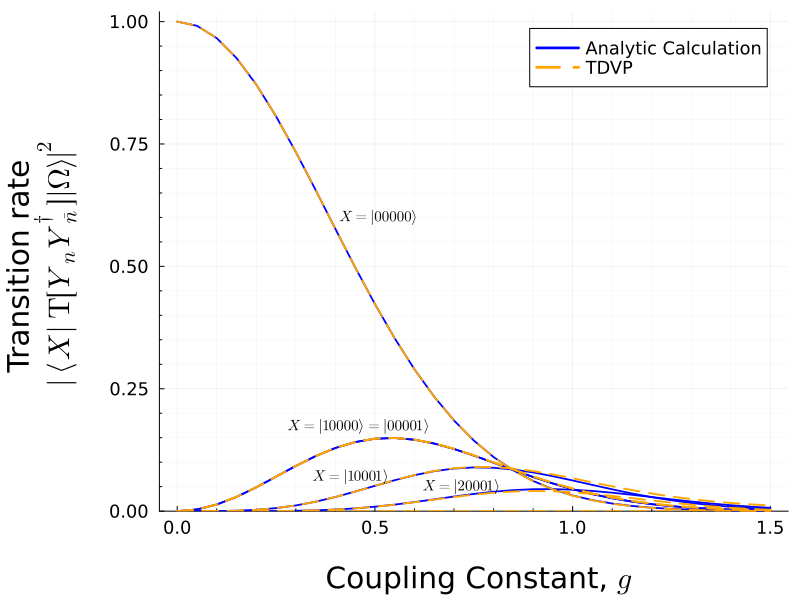

In [19]:
gr()
default(size=(800, 600))
plot(g_list, analytic_00000, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_10000, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_00001, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_10001, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_20001, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_00000, linewidth=1.9, label="TDVP", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10000, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_00001, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_00100, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10001, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_20001, linewidth=1.9, label="", linestyle=:dash, color="orange")

# Add text annotations
annotate!(0.51, 0.6, text("\$X = |00000\\rangle\$", 10))
annotate!(0.46, 0.173, text("\$X = |10000\\rangle = |00001\\rangle\$", 10))
annotate!(0.44, 0.07, text("\$X = |10001\\rangle\$", 10))
annotate!(0.72, 0.05, text("\$X = |20001\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=5 (TDVP)")

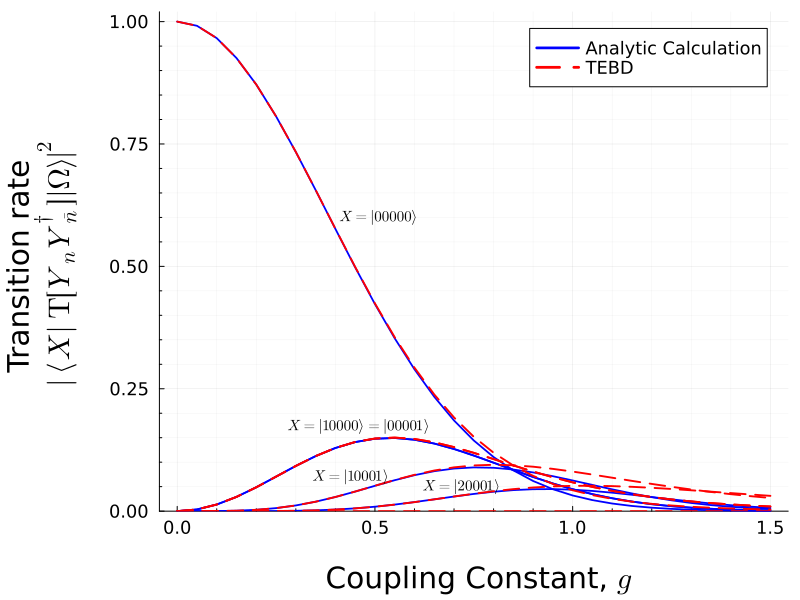

In [20]:
gr()
default(size=(800, 600))
plot(g_list, analytic_00000, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_10000, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_00001, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_10001, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_20001, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_00000_2, linewidth=1.9, label="TEBD", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_10000_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_00001_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_00100_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_10001_2, linewidth=1.9, label="", linestyle=:dash, color="red")
plot!(g_list, exp_val_list_20001_2, linewidth=1.9, label="", linestyle=:dash, color="red")

# Add text annotations
annotate!(0.51, 0.6, text("\$X = |00000\\rangle\$", 10))
annotate!(0.46, 0.173, text("\$X = |10000\\rangle = |00001\\rangle\$", 10))
annotate!(0.44, 0.07, text("\$X = |10001\\rangle\$", 10))
annotate!(0.72, 0.05, text("\$X = |20001\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=5 (TEBD)")